In [3]:
import pandas as pd
from db import Database
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')
import matplotlib.colors as mpcolors
import numpy as np

db = Database()

In [4]:

def get_df(db: Database, mwname, pcap_id, g: bool, pt: str, slot_h=1.0, nn=1, max_slots_h=0):

    if g:
        if pt == 'q':
            where = 'rn_qr=1 and is_r is false'
        elif pt == 'r':
            where = 'rn_qr=1 and is_r is true'
        elif pt == 'ok':
            where = 'rn_qr_rcode=1 and rcode = 0'
        elif pt == 'nx':
            where = 'rn_qr_rcode=1 and rcode = 3'
    else:
        if pt == 'q':
            where = 'is_r is false'
        elif pt == 'r':
            where = 'is_r is true'
        elif pt == 'ok':
            where = 'rcode = 0'
        elif pt == 'nx':
            where = 'rcode = 3'


    slot_seconds = 3600 * slot_h
    upper_where = ''
    if max_slots_h > 0:
        max_slots_time = max_slots_h/slot_h
        upper_where = f' and FLOOR(time_s_translated / {slot_seconds}) < {max_slots_time}'
        pass

    if pcap_id:
        df = pd.read_sql(f"""
        SELECT EPS{nn} < 0.5 AS pn, EPS{nn} >= 0.5 AS pp, time_s_translated, FLOOR(time_s_translated / {slot_seconds}) as "hour" from public.get_message_pcap_all3({pcap_id},0)
        where {where} {upper_where}
        """, db.engine)
    else:
        df = pd.read_sql(f"""
        SELECT EPS{nn} < 0.5 AS pn, EPS{nn} >= 0.5 AS pp, time_s_translated, FLOOR(time_s_translated / {slot_seconds}) as "hour" from public.get_message_healthy_all2()
        where {where} {upper_where}
        """, db.engine)

    df = df.groupby("hour").aggregate({"pn": "sum", "pp": 'sum'})

    df.index.name = 'slot'

    df.index = df.index - df.index.min()

    df = df.reindex(pd.Index(range(int(df.index.max()))), fill_value=0)

    df.index.name = 'slot'

    df = df.reset_index()

    if any(df.slot.value_counts() > 1):
        raise Exception('Some values are duplicated.')
    
    return df

In [25]:
dfh = get_df(db, 'healthy', None, True, 'nx', slot_h=1)
DFH = dfh[dfh.slot < 8].copy()
dfs = {
    'caphaw': get_df(db, 'caphaw', 54, True, 'nx', slot_h=1),
    'zbot': get_df(db, 'zbot', 46, True, 'nx', slot_h=1),
    'simda': get_df(db, 'simda', 58, True, 'nx', slot_h=1),
    'unknown': get_df(db, 'unknown', 57, True, 'nx', slot_h=1)
}
mws = list(dfs.keys())

In [ ]:

def bo(df_mw, dfh_or, th_p=1.0, mu=10., sigma=1.):
    th = dfh_or['pp'].max() * th_p
    values = []
    for i in range(len(df_mw) - 8):
        dfm = df_mw.iloc[i:i+8].reset_index(drop=True)
        dfh = dfh_or.copy()

        if mu > 0:
            muls = np.ceil(np.random.normal(mu, sigma, len(df_mw) - 8))
            muls[muls<0] = 0
            dfh['pp'] *= pd.Series(muls)
            pass

        df = (dfh + dfm)['pp']

        fps = (dfh['pp'] > th)
        tps = (dfm['pp'] > 0) & (df > th)
        na = (dfm['pp'] == 0).sum()
        pa = (dfm['pp'] > 0).sum()
        missed = (tps.sum() == 0) and (dfm['pp'].sum() > 0)
        raised = (tps.sum() > 0) and (dfm['pp'].sum() > 0)

        values.append([ fps.sum(), tps.sum(), na, pa, missed, raised ])
        pass
    df = pd.DataFrame(values, columns=['fpa', 'tpa', 'na', 'pa', 'missed', 'detected'])
    return df

ValueError: 'outside' option for loc='outside center right' keyword argument only works for figure legends

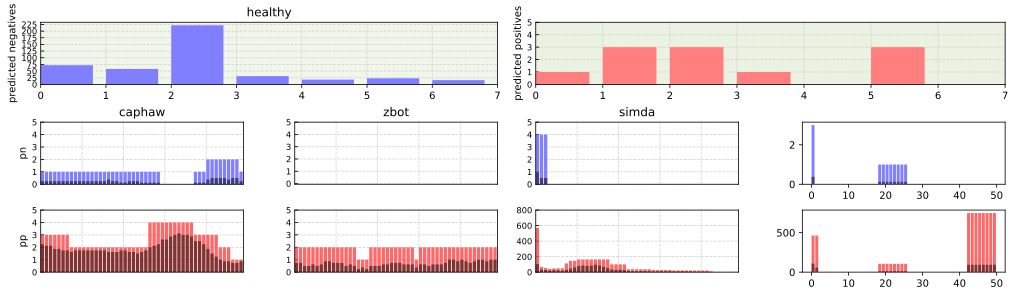

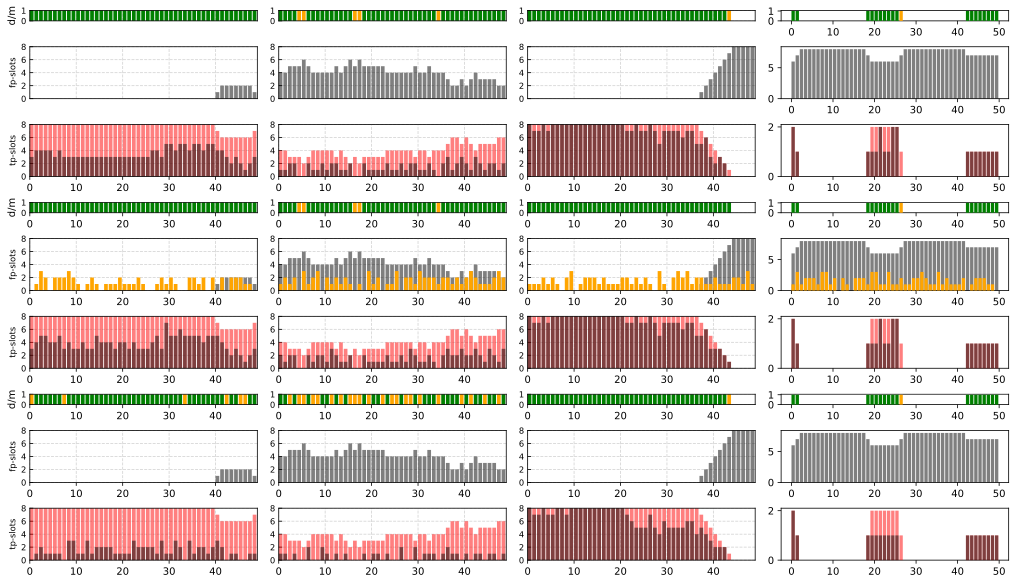

In [18]:

# fig, axs = plt.subplots(5, 4, figsize=(14,8), sharey=False, sharex='col')


dfh = dfs['healthy']

dfh.loc[9:, 'pp'] = 0
dfh.loc[9:, 'pn'] = 0

slot_1st = {
    'caphaw': 0,
    'zbot': 0,
    'simda': 0,
    'unknown': 0,
}

num_slots = 50


fig1 = plt.figure(layout="constrained", figsize=(14,4))
gs1 = fig1.add_gridspec(3, 4,  width_ratios=(1, 1, 1, 1), height_ratios=(1, 1, 1),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)



fig2 = plt.figure(layout="constrained", figsize=(14,8))
gs2 = fig2.add_gridspec(9, 4,  width_ratios=(1, 1, 1, 1), height_ratios=(.1, 0.5, 0.5, .1, 0.5, 0.5, .1, 0.5, 0.5),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)



i = 0
for mw in dfs:
    df = dfs[mw].copy()
    if mw == 'healthy':
        ax0 = fig1.add_subplot(gs1[0, 0:2])
        ax1 = fig1.add_subplot(gs1[0, 2:4])
        df = DFH.copy()
        # df['pp'] += 2
        ax0.set_xticks(list(range(8)))
        ax1.set_xticks(list(range(8)))
        ax0.set_facecolor(mpcolors.to_rgba('#cfe1b94a'))
        ax1.set_facecolor(mpcolors.to_rgba('#cfe1b96a'))
        ax0.set_ylabel('predicted negatives')
        ax1.set_ylabel('predicted positives')
    else:
        ax0 = fig1.add_subplot(gs1[1, i-1])
        ax1 = fig1.add_subplot(gs1[2, i-1])
        axf2 = [ [ fig2.add_subplot(gs2[m + mm * 3, i-1]) for m in range(3) ] for mm in range(3) ]
        df_max = df.rolling(8).max()
        df_mean = df.rolling(8).mean()
        df_bos = [
            bo(df, (DFH).copy(), th_p=1.0, mu=0),
            bo(df, (DFH).copy(), th_p=1.0, mu=1.0, sigma=0.05),
            bo(df, (DFH).copy(), th_p=2, mu=1.0, sigma=0.05),
        ]

        if num_slots:
            num_slots = num_slots if df.slot.max() > num_slots else df.slot.max()
            x0 = slot_1st[mw]
            x0_rolled = x0 + 7
            df = df.iloc[x0:x0 + num_slots]
            df_max = df_max.iloc[x0_rolled:x0_rolled + num_slots]
            df_mean = df_mean.iloc[x0_rolled:x0_rolled + num_slots]
            df_bos = [ df_bo.iloc[x0:x0 + num_slots] for df_bo in df_bos ]
            pass

        pass

    negcolor = mpcolors.to_rgba((127/255, 127/255, 255/255, 1))
    poscolor_1 = mpcolors.to_rgba((255/255, 127/255, 127/255, 0.8))
    poscolor_2 = mpcolors.to_rgba((255/255, 67/255, 67/255, 0.8))
    poscolor_3 = mpcolors.to_rgba((255/255, 33/255, 33/255, 0.8))
    black = mpcolors.to_rgba((0, 0, 0, 0.5))

    # axs[i].set_yscale('log')

    if i == 0:
        ax0.bar(df.index, df['pn'], align='edge', color=negcolor, alpha=1, zorder=3)
        ax1.bar(df.index, df['pp'], align='edge', color=poscolor_1, alpha=1, zorder=3)
    else:
        ax0.bar(df.index, df_max['pn'],  align='edge', color=negcolor,    zorder=3)
        ax0.bar(df.index, df_mean['pn'], align='edge', color=black,       zorder=3)
        ax1.bar(df.index, df_max['pp'],  align='edge', color=poscolor_2,  zorder=3)
        ax1.bar(df.index, df_mean['pp'], align='edge', color=black,       zorder=3)
        

        for m in range(3):
            df_bo = df_bos[m]
            axf2[m][0].bar(df_bo.index, df_bo['missed'], label='missed', align='edge', color='orange', zorder=3)
            axf2[m][0].bar(df_bo.index, df_bo['detected'], label='detected', align='edge', color='green', zorder=3)

            axf2[m][1].bar(df_bo.index, df_bo['na'],  label='na', align='edge', color=black, zorder=3)
            axf2[m][1].bar(df_bo.index, df_bo['fpa'], label='fpa', align='edge', color='orange', zorder=3)

            axf2[m][2].bar(df_bo.index, df_bo['pa'],  label='pa', align='edge', color='red', zorder=3, alpha=0.5)
            axf2[m][2].bar(df_bo.index, df_bo['tpa'], label='tpa', align='edge', color=black, zorder=3)
            pass
        
        if i == 1:
            ax0.set_ylabel('pn')
            ax1.set_ylabel('pp')
            for m in range(3):
                axf2[m][0].set_ylabel('d/m')
                axf2[m][1].set_ylabel('fp-slots', size='small')
                axf2[m][2].set_ylabel('tp-slots', size='small')
                pass
            pass
        if i > 0 and i == (len(dfs) - 1):
            ax.legend(loc='outside center right')
            pass
        pass

    axs = [ ax0, ax1 ] if i == 0 else ([ ax0, ax1 ] + [ ax for axs in axf2 for ax in axs ])
    [ ax.grid(True, axis='both', linestyle='--', color='lightgray', zorder=0) for ax in axs ]
    [ ax.set_axisbelow(False) for ax in axs ]

    for k, ax in enumerate(axs):

        [ ax.spines[_].set_zorder(100) for _ in 'top,right,bottom,left'.split(',') ]

        _max = df['pn' if k == 0 else 'pp'].max()

        if _max < 5:
            s, m = 1, 6
        elif _max < 10:
            s, m = 1, 10
        elif _max < 25:
            s, m = 5, 5
        elif _max < 50:
            s, m = 2, int(_max / 2) + 2
        elif _max < 100:
            s, m = 20, 6
        elif _max < 500:
            s, m = 25, int(_max / 25) + 2
        elif _max < 1000:
            s, m = 200, 5
        else:
            s, m = 25, 4
        if m < 5:
            m = 5

        if k < 2:
            ax.set_yticks(list(map(lambda x: int(s * x), range(m))))
            pass

        ax.tick_params(axis="y", direction="in", labelleft=True, labelsize='small')

        if k >= 2:
            if ((k - 2) % 3) == 0:
                ax.set_ylim(0, 1)
            else:
                ax.set_ylim(0, 8)
                ax.set_yticks([0,2,4,6,8])
                ax.tick_params(axis='y', zorder=100)
                pass
    
        xlim = list(ax.get_xlim())

        xlim[0] = -3
        if i > 0 and k < 4:
            ax.tick_params(axis="x", length=0, direction="in", labelleft=True, labelsize='small', labelcolor='white')
            pass
        for l in range(m):
            # ax.text(xlim[0] + 1, l*s, l*s, va='bottom', horizontalalignment='left', size='small')
            pass
        ax.set_xlim(0, df.index.max())
        pass

    ax0.set_title(mw)
    i += 1
    pass

# fig.tight_layout()
_ = fig1.text(0.5, -0.01, "hours", ha='center', va='bottom')
_ = fig2.text(0.5, -0.01, "hours", ha='center', va='bottom')
# fig.subplots_adjust(hspace=0.1, wspace=0.05)


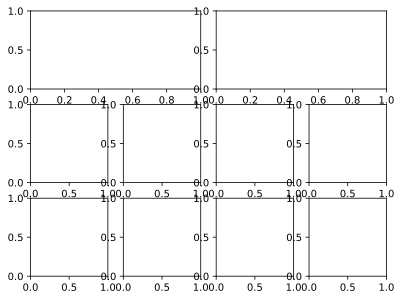

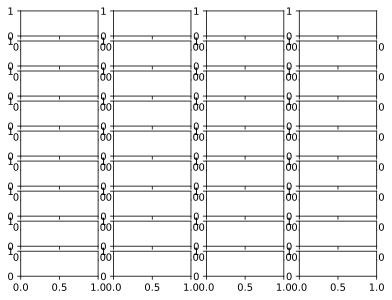

In [31]:

# fig, axs = plt.subplots(5, 4, figsize=(14,8), sharey=False, sharex='col')

import numpy as np


DFH.loc[9:, 'pp'] = 0
DFH.loc[9:, 'pn'] = 0

slot_1st = {
    'caphaw': 0,
    'zbot': 0,
    'simda': 0,
    'unknown': 0,
}

num_slots = 50

sigmas = [
    dict(th_p=1.0, mu=0, sigma=0.0),
    dict(th_p=1.0, mu=1.0, sigma=0.05),
    dict(th_p=2, mu=1.0, sigma=0.05)
]

def bo(df_mw, dfh_or, th_p=1.0, mu=10., sigma=1.):
    th = dfh_or['pp'].max() * th_p
    values = []
    for i in range(len(df_mw) - 8):
        dfm = df_mw.iloc[i:i+8].reset_index(drop=True)
        dfh = dfh_or.copy()

        if mu > 0:
            muls = np.ceil(np.random.normal(mu, sigma, len(df_mw) - 8))
            muls[muls<0] = 0
            dfh['pp'] *= pd.Series(muls)
            pass

        df = (dfh + dfm)['pp']

        fps = (dfh['pp'] > th)
        tps = (dfm['pp'] > 0) & (df > th)
        na = (dfm['pp'] == 0).sum()
        pa = (dfm['pp'] > 0).sum()
        missed = (tps.sum() == 0) and (dfm['pp'].sum() > 0)
        raised = (tps.sum() > 0) and (dfm['pp'].sum() > 0)

        values.append([ fps.sum(), tps.sum(), na, pa, missed, raised ])
        pass
    df = pd.DataFrame(values, columns=['fpa', 'tpa', 'na', 'pa', 'missed', 'detected'])
    return df


i = 0


# if mw == 'healthy':
#     ax0 = fig1.add_subplot(gs1[0, 0:2])
#     ax1 = fig1.add_subplot(gs1[0, 2:4])
#     df = DFH.copy()
#     # df['pp'] += 2
#     ax0.set_xticks(list(range(8)))
#     ax1.set_xticks(list(range(8)))
#     ax0.set_facecolor(mpcolors.to_rgba('#cfe1b94a'))
#     ax1.set_facecolor(mpcolors.to_rgba('#cfe1b96a'))
#     ax0.set_ylabel('predicted negatives')
#     ax1.set_ylabel('predicted positives')

for mw in dfs:
    df = dfs[mw].copy()
    df_max = df.rolling(8).max()
    df_mean = df.rolling(8).mean()
    df_bos = [
        bo(df, (DFH).copy(), th_p=sigma['th_p'], mu=sigma['mu'], sigma=sigma['sigma'])
        for sigma in sigmas
    ]

    if num_slots:
        num_slots = num_slots if df.slot.max() > num_slots else df.slot.max()
        x0 = slot_1st[mw]
        x0_rolled = x0 + 7
        df = df.iloc[x0:x0 + num_slots]
        df_max = df_max.iloc[x0_rolled:x0_rolled + num_slots]
        df_mean = df_mean.iloc[x0_rolled:x0_rolled + num_slots]
        df_bos = [ df_bo.iloc[x0:x0 + num_slots] for df_bo in df_bos ]
        pass
    pass



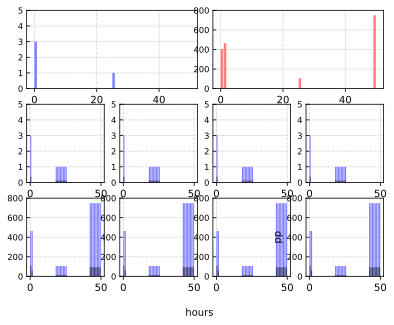

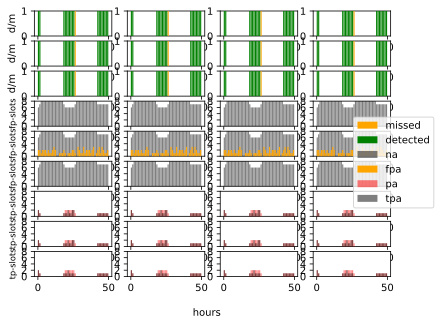

In [52]:

from re import A


fig1, axs1 = plt.subplot_mosaic(
    [
        ['h-pn', 'h-pn', 'h-pp', 'h-pp'],
        [f'{mw}-pn' for mw in mws],
        [f'{mw}-pp' for mw in mws]
    ],
)

fig2, axs2 = plt.subplot_mosaic(
    [ [ f'{mw}-{sigma}-{row}' for mw in mws] for row in ['dm', 'f', 't'] for sigma in range(len(sigmas)) ]
)

negcolor = mpcolors.to_rgba((127/255, 127/255, 255/255, 1))
poscolor_1 = mpcolors.to_rgba((255/255, 127/255, 127/255, 0.8))
poscolor_2 = mpcolors.to_rgba((255/255, 67/255, 67/255, 0.8))
poscolor_3 = mpcolors.to_rgba((255/255, 33/255, 33/255, 0.8))
black = mpcolors.to_rgba((0, 0, 0, 0.5))


axs1['h-pn'].bar(df.index, df['pn'], align='edge', color=negcolor, alpha=1, zorder=3)
axs1['h-pp'].bar(df.index, df['pp'], align='edge', color=poscolor_1, alpha=1, zorder=3)

for mw in mws:
    for l in ['pn', 'pp']:
        axs1[f'{mw}-{l}'].bar(df.index, df_max[l],  align='edge', color=negcolor,    zorder=3)
        axs1[f'{mw}-{l}'].bar(df.index, df_mean[l], align='edge', color=black,       zorder=3)
        pass
    pass
axs1[f'{mws[-1]}-{l}'].set_ylabel(l)

def _lbl(mw, sigma, l):
    return l if mw == mws[0] and sigma == 0 else ''
for mw in dfs:
    for sigma in range(len(sigmas)):
        df_bo = df_bos[sigma]

        axs2[f'{mw}-{sigma}-dm'].bar(df_bo.index, df_bo['missed'], label=_lbl(mw, sigma, 'missed'), align='edge', color='orange', zorder=3)
        axs2[f'{mw}-{sigma}-dm'].bar(df_bo.index, df_bo['detected'], label=_lbl(mw, sigma, 'detected'), align='edge', color='green', zorder=3)

        axs2[f'{mw}-{sigma}-f'].bar(df_bo.index, df_bo['na'],  label=_lbl(mw, sigma, 'na'), align='edge', color=black, zorder=3)
        axs2[f'{mw}-{sigma}-f'].bar(df_bo.index, df_bo['fpa'], label=_lbl(mw, sigma, 'fpa'), align='edge', color='orange', zorder=3)

        axs2[f'{mw}-{sigma}-t'].bar(df_bo.index, df_bo['pa'],  label=_lbl(mw, sigma, 'pa'), align='edge', color='red', zorder=3, alpha=0.5)
        axs2[f'{mw}-{sigma}-t'].bar(df_bo.index, df_bo['tpa'], label=_lbl(mw, sigma, 'tpa'), align='edge', color=black, zorder=3)
        pass
        
for sigma in range(len(sigmas)):
    axs2[f'{mws[0]}-{sigma}-dm'].set_ylabel('d/m')
    axs2[f'{mws[0]}-{sigma}-f'].set_ylabel('fp-slots', size='small')
    axs2[f'{mws[0]}-{sigma}-t'].set_ylabel('tp-slots', size='small')
    pass

# axs2[f'{mws[-1]}-{sigma}-0'].legend(loc='outside center right')
# axs2[f'{mws[-1]}-{sigma}-1'].legend(loc='outside center right')
# axs2[f'{mws[-1]}-{sigma}-2'].legend(loc='outside center right')

def set_ylim(ax):
    _max = ax.get_ylim()[1]
    if _max < 5:
        s, m = 1, 6
    elif _max < 10:
        s, m = 1, 10
    elif _max < 25:
        s, m = 5, 5
    elif _max < 50:
        s, m = 2, int(_max / 2) + 2
    elif _max < 100:
        s, m = 20, 6
    elif _max < 500:
        s, m = 25, int(_max / 25) + 2
    elif _max < 1000:
        s, m = 200, 5
    else:
        s, m = 25, 4
    if m < 5:
        m = 5
    ax.set_yticks(list(map(lambda x: int(s * x), range(m))))
    return s, m

if True:
    for kax in axs1:
        ax = axs1[kax]
        ax.tick_params(axis="y", direction="in", labelleft=True, labelsize='small')

        ax.grid(True, axis='both', linestyle='--', color='lightgray', zorder=0)
        ax.set_axisbelow(False)
        [ ax.spines[_].set_zorder(100) for _ in 'top,right,bottom,left'.split(',') ]

        set_ylim(ax)
        ax.tick_params(axis="y", direction="in", labelleft=True, labelsize='small')
        pass

    for mw in mws:
        for sigma in range(len(sigmas)):
            axs2[f'{mw}-{sigma}-dm'].set_ylim(0, 1)

            for i in [ 'f', 't' ]:
                axs2[f'{mw}-{sigma}-{i}'].set_ylim(0, 8)
                axs2[f'{mw}-{sigma}-{i}'].set_yticks([ 0, 2, 4, 6, 8 ])
                axs2[f'{mw}-{sigma}-{i}'].tick_params(axis='y', zorder=100)
                pass
    
    #     xlim = list(ax.get_xlim())

    #     xlim[0] = -3
    #     if i > 0 and k < 4:
    #         ax.tick_params(axis="x", length=0, direction="in", labelleft=True, labelsize='small', labelcolor='white')
    #         pass
    #     for l in range(m):
    #         # ax.text(xlim[0] + 1, l*s, l*s, va='bottom', horizontalalignment='left', size='small')
    #         pass
    #     ax.set_xlim(0, df.index.max())
    #     pass

    # ax0.set_title(mw)
    pass

# fig.tight_layout()
_ = fig1.text(0.5, -0.01, "hours", ha='center', va='bottom')
_ = fig2.text(0.5, -0.01, "hours", ha='center', va='bottom')
# fig.subplots_adjust(hspace=0.1, wspace=0.05)

legend = fig2.legend(loc='outside center right')

In [133]:
def capture(mw, ax_n, ax_p):
    df = dfs[mw].copy()

    df_max = df.rolling(8).max()
    df_mean = df.rolling(8).mean()

    num_slots = 50

    if num_slots:
        num_slots = num_slots if df.slot.max() > num_slots else df.slot.max()
        x0 = slot_1st[mw]
        x0_rolled = x0 + 7
        df = df.iloc[x0:x0 + num_slots]
        df_max = df_max.iloc[x0_rolled:x0_rolled + num_slots]
        df_mean = df_mean.iloc[x0_rolled:x0_rolled + num_slots]
        pass

    ax_n.bar(df.index, df_max['pn'],  align='edge', color=negcolor,    zorder=3)
    ax_n.bar(df.index, df_mean['pp'], align='edge', color=black,       zorder=3)

    ax_p.bar(df.index, df_max['pn'],  align='edge', color=poscolor_2,    zorder=3)
    ax_p.bar(df.index, df_mean['pp'], align='edge', color=black,       zorder=3)
    pass


def simulation(ax_md, ax_n, ax_p, mw, sigma):

    df = dfs[mw]

    df = bo(df.copy(), DFH.copy(), sigma['th_p'], sigma['mu'], sigma['sigma'])

    df = df.iloc[0:50]

    ax_md.tick_params(axis="x", labelbottom=False, length=0)
    ax_n.tick_params(axis="x", labelbottom=False, length=0)
    ax_n.tick_params(axis="y", bottom=True)

    ax_md.bar(df.index, df['missed'], align='edge', color='orange', zorder=3)
    ax_md.bar(df.index, df['detected'], align='edge', color='green', zorder=3)

    # ax_f.bar(df.index, df['na'], align='edge', color='blue', zorder=3, alpha=0.5)
    ax_n.bar(df.index, df['fpa'], align='edge', color='orange', zorder=3, alpha=0.8)

    ax_p.bar(df.index, df['pa'], align='edge', color='red', zorder=3, alpha=0.5)
    ax_p.bar(df.index, df['tpa'], align='edge', color='green', zorder=4, alpha=0.5)

    ax_n.grid(True, axis='both', linestyle='--', color='lightgray', zorder=0)
    ax_p.grid(True, axis='both', linestyle='--', color='lightgray', zorder=0)

    ax_md.set_ylim(0, 1)
    ax_n.set_ylim(0, 9.5)
    ax_p.set_ylim(0, 9.5)

    ax_md.set_yticks([])
    ax_md.set_xticks(ax_p.get_xticks(), [])
    ax_n.set_xticks(ax_p.get_xticks(), [])

    ax_md.set_xlim(-2, 52)
    ax_n.set_xlim(-2, 52)
    ax_p.set_xlim(-2, 52)

    ax_n.set_yticks([ i for i in range(0,9,2)])
    ax_p.set_yticks([ i for i in range(0,9,2)])
    pass


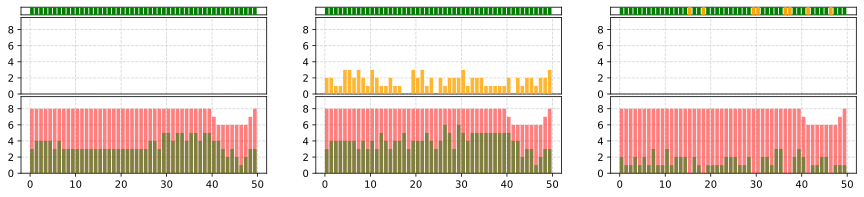

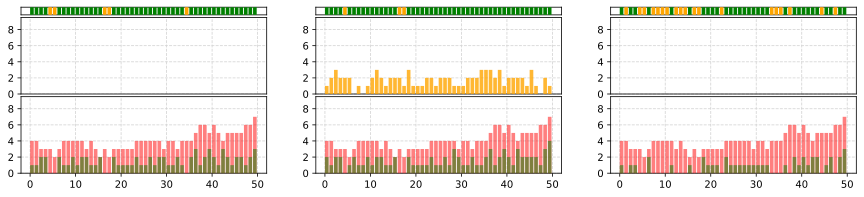

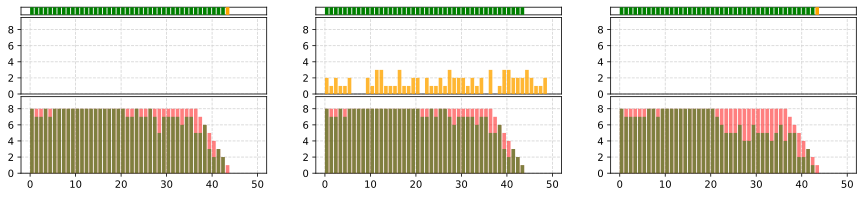

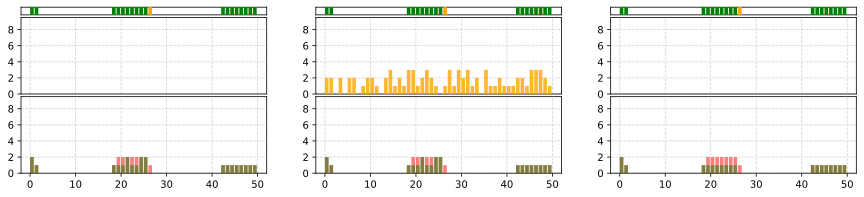

In [136]:

sigmas = [
    dict(th_p=1.0, mu=0, sigma=0.0),
    dict(th_p=1.0, mu=1.0, sigma=0.05),
    dict(th_p=2, mu=1.0, sigma=0.05)
]

for mwidx, mw in enumerate(mws):
    fig = plt.figure(figsize=(15,3))
    gs = fig.add_gridspec(3, len(sigmas), height_ratios=( 0.1, 1.0, 1. ), hspace=0.05)
    for idxsigma, sigma in enumerate(sigmas):
        # gs.GridSpecFromSubplotSpec()
        ax1 = fig.add_subplot(gs[0, idxsigma])
        ax2 = fig.add_subplot(gs[1, idxsigma])
        ax3 = fig.add_subplot(gs[2, idxsigma])

        simulation(ax1, ax2, ax3, mw, sigma)
        pass
    pass

In [ ]:


for idxsigma, sigma in enumerate(sigmas):
    fig = plt.figure(figsize=(15,3))
    gs = fig.add_gridspec(len(sigmas), len(mws), height_ratios=( 0.1, 1., 1. ), hspace=0.05)
    for mwidx, mw in enumerate(mws):
        # gs.GridSpecFromSubplotSpec()
        ax1 = fig.add_subplot(gs[0, mwidx])
        ax2 = fig.add_subplot(gs[1, mwidx])
        ax3 = fig.add_subplot(gs[2, mwidx])

        scatter_bar(ax1, ax2, ax3, mw, sigma)
        pass
    pass